### Postprocess of the complete demo

In [29]:
import json
import os
import random
import alphashape

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from statsmodels.stats.multitest import multipletests

In [31]:
red = '#d96256'
lightorange = '#fabc2e'
lightgreen = '#93c572'
lightblue = '#5d8aa8'
darkblue = '#284d88'
darkgray ='#545454'

colors5 = [red, lightorange, lightgreen, lightblue, darkblue]

#### Load p values and estimates

In [11]:
res_dir = 'your_dir/ELLA/scripts/demo/complete_demo/lightning_logs/run1'

types_list = ['demo']
genes_dict = {}
p_raw_dict = {}
p_combined_dict = {}
p_fdr_dict = {}
lam_dict = {}
delta_lam_dict = {}

genes = []
p_raw = []
p_cauchy = []
lam = []
delta_lam = []

t = 'demo'

for i in range(50):
    path = f'{res_dir}/gene_{i}_estimation_result.json'
    if os.path.exists(path):
        with open(path, "r", encoding="utf-8") as f:
            res = json.load(f)
            genes.append(res['gene_id'])
            p_raw.append(res['p_raw'])
            p_cauchy.append(res['p_cauchy'])
            lam.append(res['lam_weighted'])
            delta_lam.append(np.max(res['lam_weighted'])-np.min(res['lam_weighted']))
reject, p_fdr, _, _ = multipletests(p_cauchy, alpha=0.05, method='fdr_by')

genes_dict[t] = np.array(genes)
p_raw_dict[t] = np.array(p_raw)
p_combined_dict[t] = np.array(p_cauchy)
p_fdr_dict[t] = np.array(p_fdr)
lam_dict[t] = lam
delta_lam_dict[t] = np.array(delta_lam)

#### Pattern clustering 

In [12]:
n_bins = 50 # number of bins of the estimated lam
thre_pv = 0.05 # significant level of fdr corrected p values
thre_delta_lam = 1e-10 # min diff of the estimated lam (max-min) so as to be considered as non-constant
K = 8 # max num of clusters

In [13]:
# extract 11 lam values
x_points_ = np.arange(0,n_bins,10)
x_points = np.append(x_points_, n_bins-1)

sig_lam_points_std_dict = {}
sig_lam_dict = {}
sig_gl_dict = {}
n_sig = []

for t in types_list:
    pv_t = p_fdr_dict[t]
    lam_t = np.array(lam_dict[t])
    delta_lam_t = delta_lam_dict[t]
    gl_t = genes_dict[t]
    
    sig_lam_t = lam_t[(pv_t<=thre_pv)&(delta_lam_t>thre_delta_lam),:]
    sig_gl_t = gl_t[(pv_t<=thre_pv)&(delta_lam_t>thre_delta_lam)]
    
    lam_points_t = sig_lam_t[:,x_points]
    lam_points_std_t = np.zeros(lam_points_t.shape)
    for j in range(lam_points_t.shape[0]):
        lam_j = lam_points_t[j,:]
        lam_points_std_t[j,:] = (lam_j-np.min(lam_j))/(np.max(lam_j)-np.min(lam_j)) # min-max std
    
    sig_lam_points_std_dict[t] = lam_points_std_t
    sig_lam_dict[t] = sig_lam_t
    sig_gl_dict[t] = sig_gl_t
    n_sig.append(len(sig_gl_t))

In [14]:
# concatenate sig std lam (11 values) across cell types
sig_lam_points_std_merged = np.concatenate(list(sig_lam_points_std_dict.values()), axis=0)

# concatenate sig lam
sig_lam_merged = np.concatenate(list(sig_lam_dict.values()), axis=0)

In [15]:
# compute the 1st derivative of lam std
sig_lam_points_std_merged_dev = sig_lam_points_std_merged[:,1:] - sig_lam_points_std_merged[:,:-1]
# min-max std
min_ = np.min(sig_lam_points_std_merged_dev, axis=1)
max_ = np.max(sig_lam_points_std_merged_dev, axis=1)
min_mat = np.tile(min_, (sig_lam_points_std_merged_dev.shape[1],1)).transpose()
max_mat = np.tile(max_, (sig_lam_points_std_merged_dev.shape[1],1)).transpose()
sig_lam_points_std_merged_dev_std = (sig_lam_points_std_merged_dev-min_mat)/(max_mat-min_mat)

In [16]:
# kmeans clustering
print(f'<<< manually specify the max number of clusters K={K}')

# random seed
random.seed(2024)

kmeans_res = {}

X = np.concatenate((sig_lam_points_std_merged_dev_std, sig_lam_points_std_merged), axis=1)
    
output_K = {}
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
for k in range(1, K+1):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=200, n_init=5)
    pred_y = kmeans.fit_predict(X)
    output_K['pred'+str(k)] = pred_y
    output_K['center'+str(k)] = kmeans.cluster_centers_
    # Elbow
    distortions.append(sum(np.min(cdist(X, kmeans.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeans.inertia_)
    mapping1[k] = sum(np.min(cdist(X, kmeans.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeans.inertia_

<<< manually specify the max number of clusters K=8


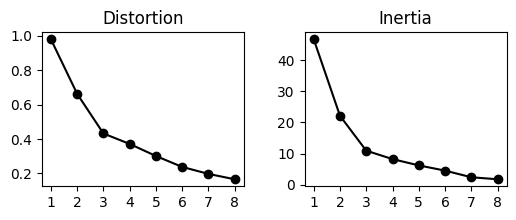

In [17]:
# visualize distortion and inertias for choosing the optimal number of clusters
nr = 1
nc = 2
ss_nc = 3
ss_nr = 2
fig = plt.figure(figsize=(nc*ss_nc, nr*ss_nr))
gs = fig.add_gridspec(nr,nc,
                      width_ratios=[1]*nc,
                      height_ratios=[1]*nr)
gs.update(wspace=0.3, hspace=0.3)

# distortion
ax = plt.subplot(gs[0,0])
x = np.arange(K)+1
ax.plot(x, distortions, 'o-', color='black')
ax.set_title('Distortion')
__ = ax.set_xticks(x,x)

# inertia
ax = plt.subplot(gs[0,1])
x = np.arange(K)+1
ax.plot(x, inertias, 'o-', color='black')
ax.set_title('Inertia')
__ = ax.set_xticks(x,x)

In [18]:
# choose optimal number of pattern clusters based on distortion and inertia

K_opt = 5 # <<<<<

print(f'<<< choose the optimal number of clusters K_opt={K_opt}')

<<< choose the optimal number of clusters K_opt=5


In [19]:
# re-orgnize cluster labels based on "peak" from 0 to 1
cluster_label_old = output_K['pred'+str(K_opt)]
center_argmax = np.zeros(K_opt)
for k in range(K_opt):
    center_argmax[k] = np.mean(np.argmax(sig_lam_points_std_merged[cluster_label_old==k,:], axis=1))
    
# build a dict of key=old label val=new label
order = center_argmax.argsort()
ranks = order.argsort()
update_label_dict = dict(zip(np.arange(K_opt), ranks))

# update the labels
cluster_label = np.zeros_like(cluster_label_old)
for k in update_label_dict.keys():
    cluster_label[cluster_label_old==k] = update_label_dict.get(k)

In [20]:
# create dictionary of clustering labels
num_sig = []
for t in types_list: 
    pv_t = p_fdr_dict[t]
    delta_lam_t = delta_lam_dict[t]
    num_sig.append(np.sum((pv_t<=thre_pv)&(delta_lam_t>thre_delta_lam)))

label_dict = {}
for it, t in enumerate(types_list):
    idx1 = int(np.sum(n_sig[:it]))
    idx2 = idx1 + n_sig[it]
    pv_t = p_fdr_dict[t]
    delta_lam_t = delta_lam_dict[t]
    label_t = np.full(len(pv_t), -1)
    cluster_label_t = cluster_label[idx1:idx2]
    label_t[(pv_t<=thre_pv)&(delta_lam_t>thre_delta_lam)] = cluster_label_t
    label_dict[t] = label_t

#### Plots

[-1  0  1  2  3  4]
[ 5 12  7 11  9  6]


Text(0.5, 0, 'Number of genes')

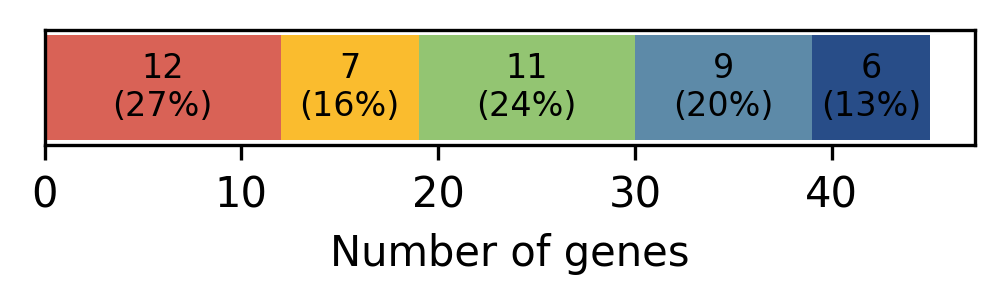

In [21]:
# barplot of number of genes in each pattern cluster

label_all = np.concatenate(list(label_dict.values()))
label_cluster, label_num = np.unique(label_all, return_counts=True)
print(label_cluster)
print(label_num)

bar_width = 0.5
bar_positions = [0, 1]

nr = 1
nc = 1
ss_nr = 0.5
ss_nc = 4
fig = plt.figure(figsize=(nc*ss_nc, nr*ss_nr), dpi=300)
gs = fig.add_gridspec(nr, nc,
                      width_ratios=[1]*nc,
                      height_ratios=[1]*nr)
gs.update(wspace=0.0, hspace=0.0)
ax = plt.subplot(gs[0, 0])

# sig genes
labels_num_sig = label_num[1:]
left = 0
for i in range(K_opt):
    ax.barh(bar_positions[0], labels_num_sig[i], bar_width, left=left, color=colors5[i])
    left += labels_num_sig[i]
    ax.text(left - labels_num_sig[i]/2, bar_positions[0], f'{labels_num_sig[i]}\n({labels_num_sig[i]/np.sum(labels_num_sig)*100:.0f}%)', fontsize=8, ha='center', va='center', color='black')
ax.set_yticks([])
ax.set_xlabel('Number of genes')

Text(0.5, 0, 'Relative position')

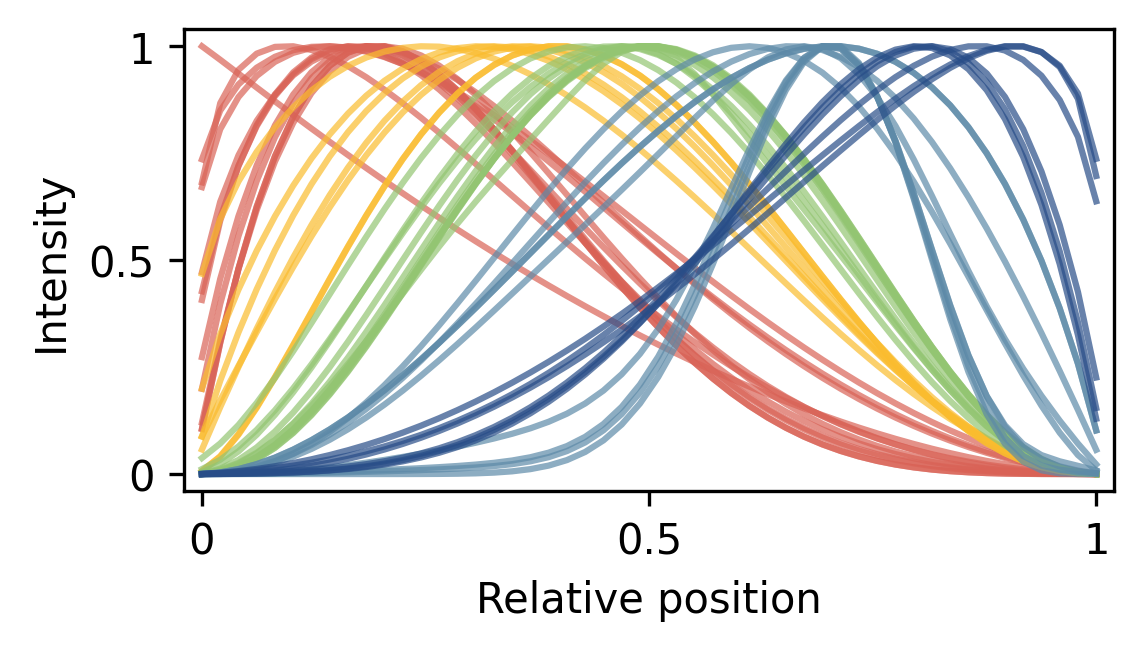

In [22]:
# plot estimated patterns (lam)

X = sig_lam_merged
x = np.linspace(0, 1, n_bins)

nr = 1
nc = 2
ss_nc = 4
ss_nr = 2
fig = plt.figure(figsize=(nc*ss_nc, nr*ss_nr), dpi=300)
gs = fig.add_gridspec(nr,nc,
                      width_ratios=[1]*nc,
                      height_ratios=[1]*nr)
gs.update(wspace=0.0, hspace=0.0)
ax = plt.subplot(gs[0,0])

for k in range(K_opt):
    idx_k = np.where(cluster_label==k)[0] 
    X_k = X[idx_k,:]
    for j in range(X_k.shape[0]):
        y = X_k[j,:]
        y_std = (y-np.min(y))/(np.max(y)-np.min(y)) # min-max std
        ax.plot(x,y_std, alpha=0.7, color=colors5[k])
        
ax.set_xlim(-0.02, 1.02)
ax.set_ylim(-0.04, 1.04)
__ = ax.set_xticks([0,0.5,1], [0,0.5,1])
__ = ax.set_yticks([0,0.5,1], [0,0.5,1])   
ax.set_ylabel('Intensity')
ax.set_xlabel('Relative position')

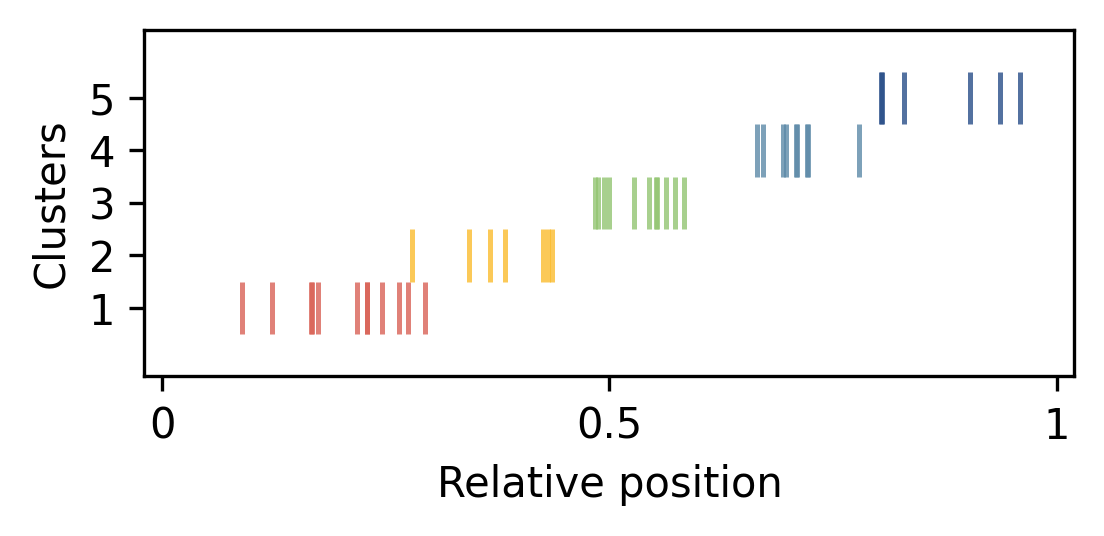

In [23]:
# pattern scores event plot
score_dict = {}
for t in types_list:
    lam_t = lam_dict[t]
    score_t = []
    for lam in lam_t:
        score_t.append(np.argmax(lam)/len(lam))
    score_dict[t] = np.array(score_t)
    
scores_all = np.concatenate(list(score_dict.values()))
labels_all = np.concatenate(list(label_dict.values()))
scores_all_sig = scores_all[labels_all>-1]
labels_all_sig = labels_all[labels_all>-1]

nr = 1
nc = 1
ss_nc = 4
ss_nr = 1.5
fig = plt.figure(figsize=(nc*ss_nc, nr*ss_nr), dpi=300)
gs = fig.add_gridspec(nr,nc,
                      width_ratios=[1]*nc,
                      height_ratios=[1]*nr)
gs.update(wspace=0.0, hspace=0.0)
ax = plt.subplot(gs[0, 0])

alpha=0.8
ll=1
lw=1.2

for k in range(5):
    scores_k = scores_all_sig[labels_all_sig==k]
    ax.eventplot([scores_k + np.random.uniform(0, 0.1, len(scores_k))], # for avoiding exact overlap
                 orientation='horizontal', 
                 colors=[colors5[k]],
                 alpha=alpha,
                 linelengths=ll, lw=lw, lineoffsets=k)

ax.set_xlim(-0.02, 1.02)
ax.set_xticks([0,0.5,1], [0,0.5,1])
__ = ax.set_yticks(np.arange(K_opt), np.arange(1,K_opt+1))
__ = ax.set_ylabel('Clusters')
__ = ax.set_xlabel('Relative position')

#### Visualize cells

In [24]:
path = 'your_dir/ELLA/scripts/demo/complete_demo/complete_demo_data.pkl'
input_dict = pd.read_pickle(path)
input_dict.keys()

dict_keys(['types', 'cells', 'cells_all', 'genes', 'cell_seg', 'nucleus_seg', 'expr'])

In [26]:
# cell IDs
cells = input_dict['cells']['fibroblast']
# gene IDs
genes = input_dict['genes']['fibroblast']
# FDR corrected p values
pv = p_fdr_dict['demo']
# estimated expression intensities
lam = lam_dict['demo']
# pattern cluster label
lab = label_dict['demo']
# cell segmentations
cell_seg = input_dict['cell_seg']
# nucleus segmentations
nucleus_seg = input_dict['nucleus_seg']
# gene expressions
expr = input_dict['expr']

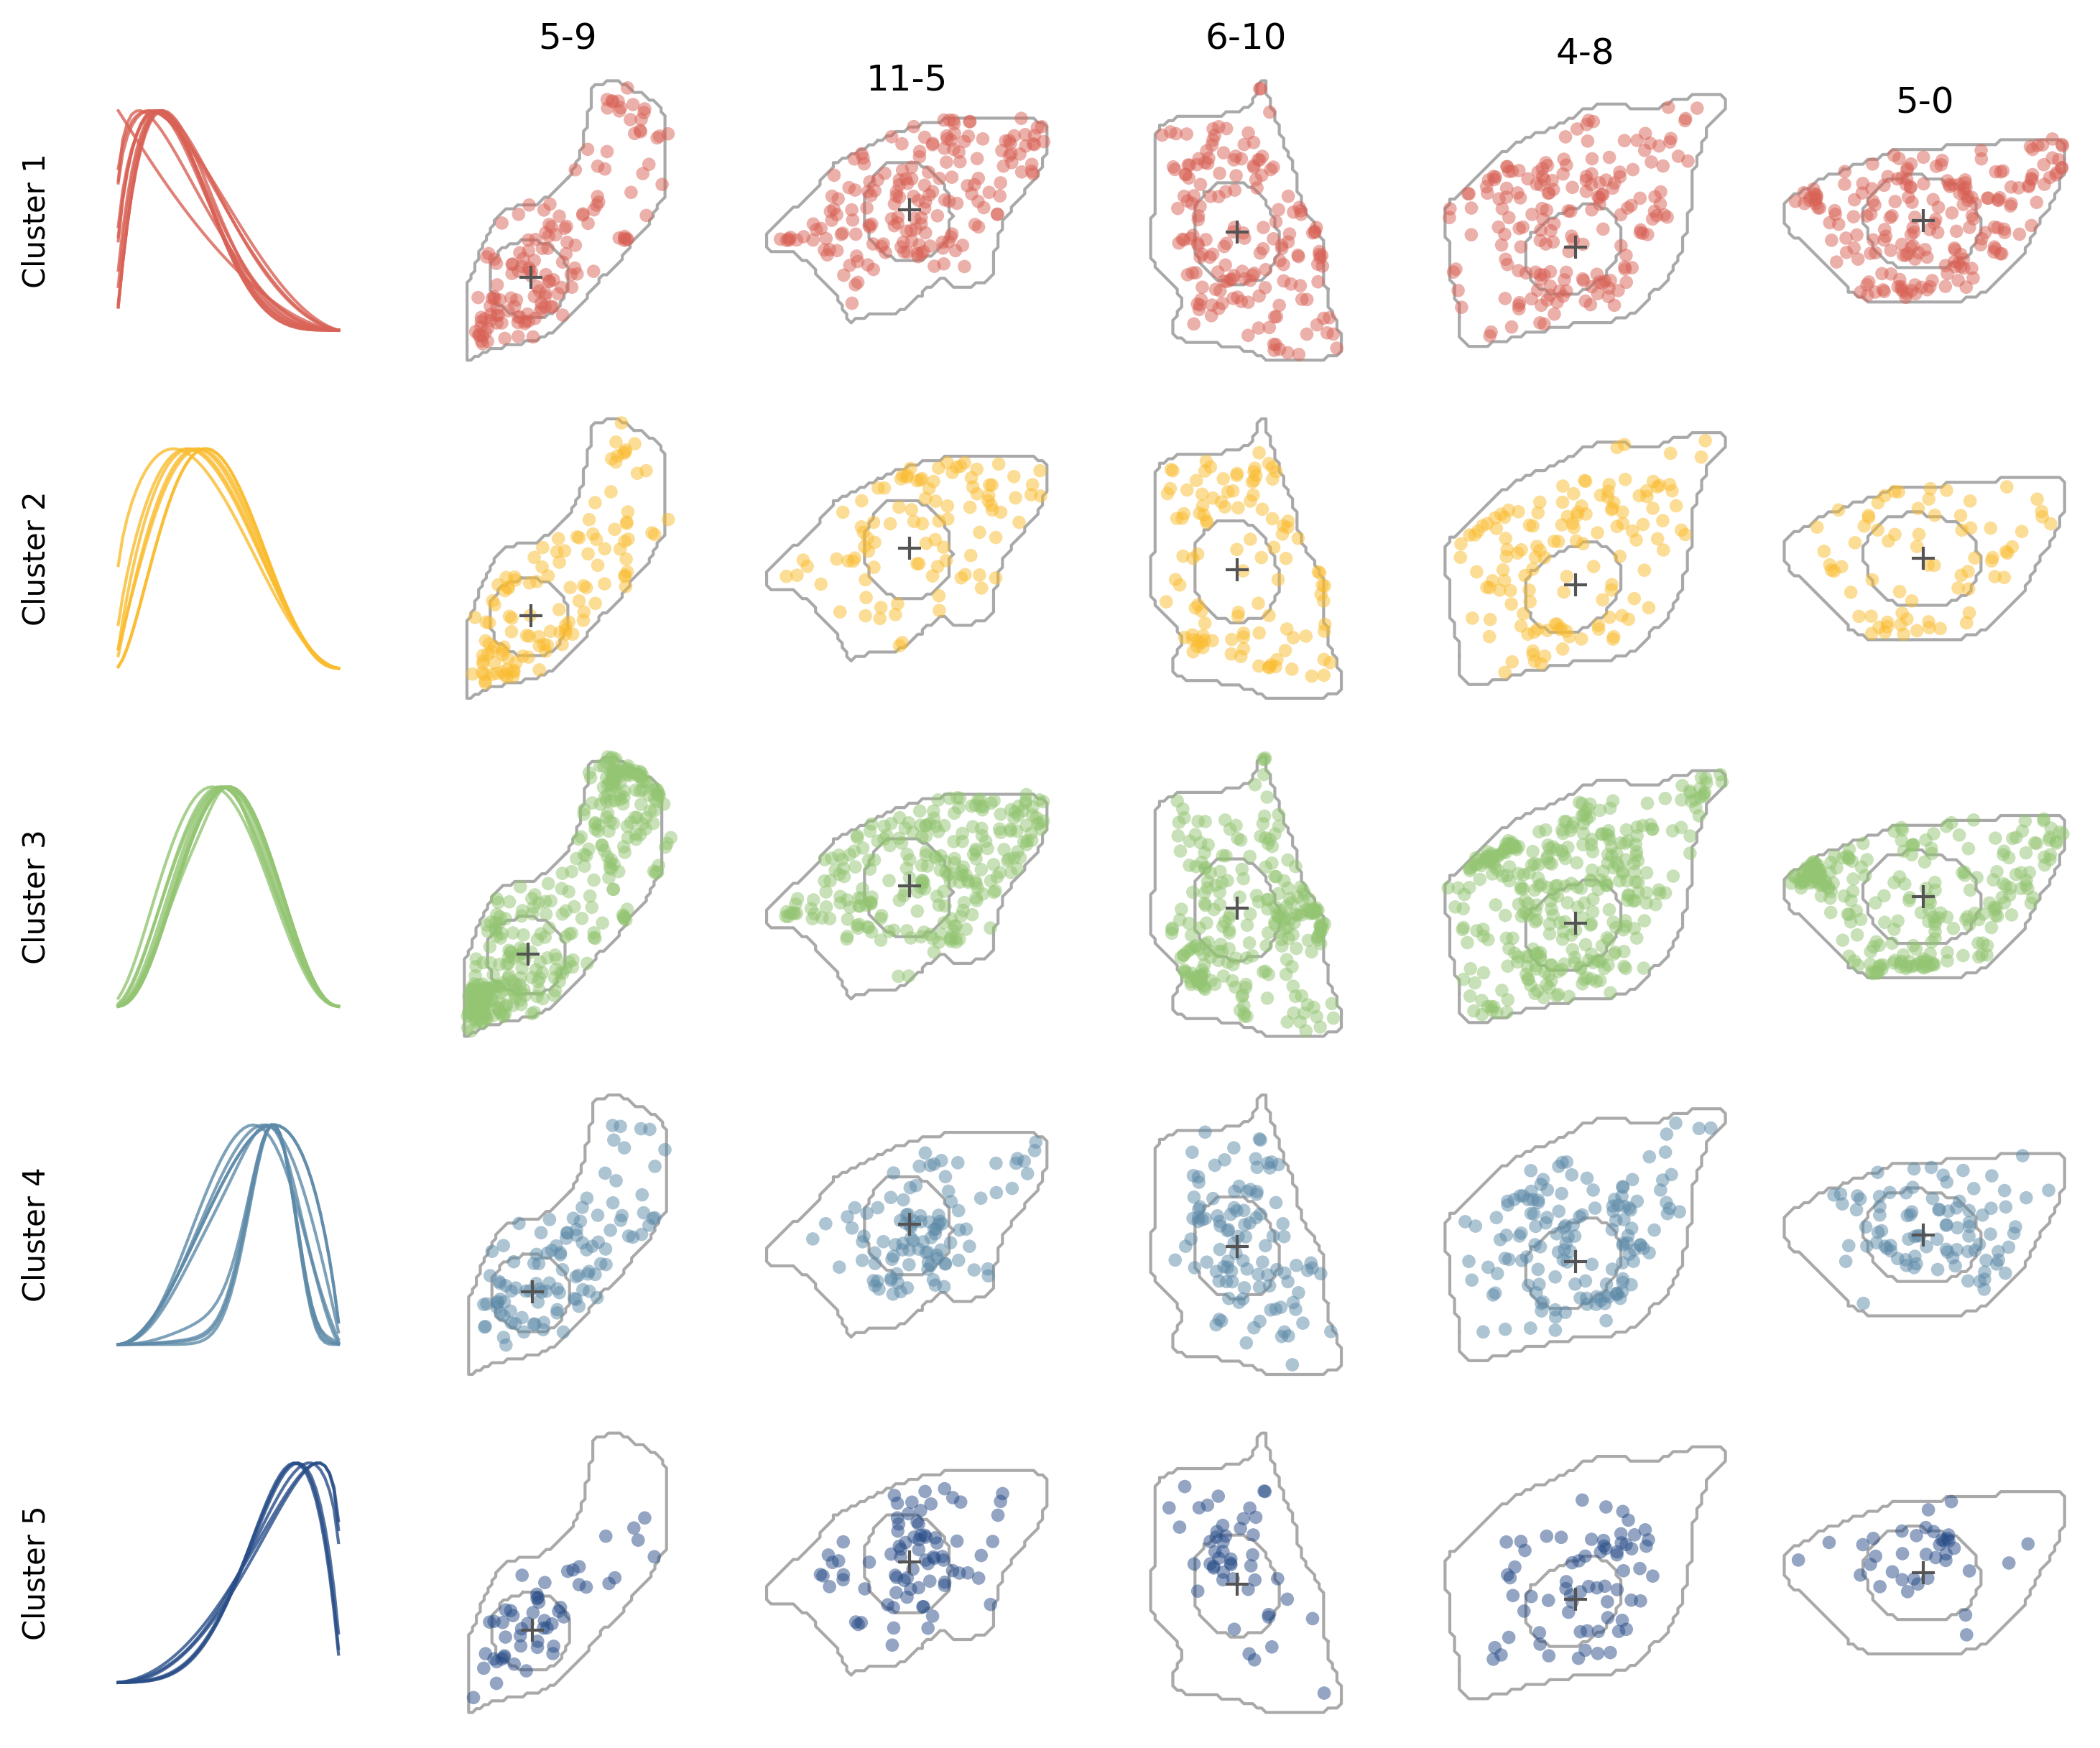

In [33]:
# plot cells and genes
cl_plot= ['5-9', '11-5', '6-10', '4-8', '5-0']
K = 5

nr = K
nc = len(cl_plot)+1
ss_nr = 2
ss_nc = 2
fig = plt.figure(figsize=(nc*ss_nc, nr*ss_nr), dpi=300)
gs = fig.add_gridspec(nr, nc,
                      width_ratios=[1]*nc,
                      height_ratios=[1]*nr)
gs.update(wspace=0.1, hspace=0.1)

# plot estimated expression intensities 
for k in range(K):
    ax = plt.subplot(gs[k,0])
    lams_k = np.array(lam)[lab==k,:]
    for j in range(lams_k.shape[0]):
        lam_g = lams_k[j,:]
        lam_g_std = (lam_g-np.min(lam_g))/(np.max(lam_g)-np.min(lam_g))
        ax.plot(np.linspace(0,1,len(lam_g_std)), lam_g_std, lw=1, alpha=0.8, color=colors5[k])
    ax.set_xlim((-0.2, 1.2))
    ax.set_ylim((-0.2, 1.2))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel(f'Cluster {k+1}')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

# plot cells and genes
for i, c in enumerate(cl_plot):
    for k in range(K):
        ax = plt.subplot(gs[k,i+1])
        gl = np.array(genes)[lab==k]
        cell_seg_c = cell_seg[cell_seg.cell==c]
        nucleus_seg_c = nucleus_seg[nucleus_seg.cell==c]
        expr_c = expr[expr.cell==c]

        # cell segmentation
        x_reduced = (cell_seg_c.x.values//10) * 10 # reduce resolution to speedup alphashape
        y_reduced = (cell_seg_c.y.values//10) * 10
        points = np.stack((x_reduced, y_reduced)).transpose()
        unique_points = np.unique(points, axis=0)
        alpha_shape_ = alphashape.alphashape(unique_points, 0.1)
        cb_x_, cb_y_ = alpha_shape_.exterior.xy
        ax.plot(cb_x_, cb_y_, 
                alpha=0.5,
                color=darkgray, lw=1, zorder=1)

        # nuclear segmentation
        x_reduced = (nucleus_seg_c.x.values//10) * 10 # reduce res to speedup alphashape
        y_reduced = (nucleus_seg_c.y.values//10) * 10
        points = np.stack((x_reduced, y_reduced)).transpose()
        unique_points = np.unique(points, axis=0)
        alpha_shape_ = alphashape.alphashape(unique_points, 0.1)
        cb_x_, cb_y_ = alpha_shape_.exterior.xy
        ax.plot(cb_x_, cb_y_, 
                alpha=0.5,
                color=darkgray, lw=1, zorder=1)

        # gene expr
        expr_c_g = expr_c[expr_c.gene.isin(gl)]
        ax.scatter(expr_c_g.x,
                   expr_c_g.y,
                   s = 20,
                   edgecolor='none',
                   color=colors5[k],
                   alpha=0.5,
                   zorder=2)

        # cell center
        xc = expr_c.centerX.iloc[0]
        yc = expr_c.centerY.iloc[0]
        ax.scatter(xc, yc, c=darkgray, marker='+',lw=1, s=60, zorder=3)

        ax.set_aspect('equal', adjustable='box')
        #ax.axis('off')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.set_xticks([])
        ax.set_yticks([])
        
        if k==0:
            ax.set_title(c)